In [1]:
%matplotlib inline
import glob, os, sys
from astropy import coordinates as coords
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import concatenate

from astropy.io import fits
from astropy.io.fits import getdata
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM

import numpy.polynomial.polynomial as poly
from multiprocessing import Pool

from varselect import qso_fit
from varselect import myvarlc

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['axes.linewidth'] = 1.5

### Read Light Curve Data

Get C3 g-band light curves:

Y1-Y6:

`with SNVAR_TEMP_1 as (select CATALOGNAME, MAG_ZERO, SIGMA_MAG_ZERO, MAG_ONE, SIGMA_MAG_ONE, MJD_OBS from  Y6A1_EXPOSURE join Y6A1_ZEROPOINT on Y6A1_EXPOSURE.expnum = Y6A1_ZEROPOINT.expnum where field like 'SN-C3' and Y6A1_ZEROPOINT.flag < 16 and Y6A1_ZEROPOINT.source='FGCM' and Y6A1_ZEROPOINT.version='y6a1_v2.1' and MJD_OBS>56400 and EXPTIME > 30 order by CATALOGNAME ) select RA, DEC, MJD_OBS, Y6A1_FINALCUT_OBJECT.FLUX_PSF*POWER(10,-0.4*MAG_ZERO+9) as FLUX_PSF, SQRT(POWER(1.09*SIGMA_MAG_ZERO*Y6A1_FINALCUT_OBJECT.FLUX_PSF, 2) + POWER(Y6A1_FINALCUT_OBJECT.FLUXERR_PSF, 2))*POWER(10,-0.4*MAG_ZERO+9) as FLUXERR_PSF, SPREAD_MODEL, BAND from  Y6A1_FINALCUT_OBJECT, SNVAR_TEMP_1 where CATALOGNAME = FILENAME and BAND='g' order by DEC, RA; > /data/des80.a/data/cburke/y6a1_c3_g_light_curves.csv`

SV:

`with SNVAR_TEMP_1 as (select CATALOGNAME, MAG_ZERO, SIGMA_MAG_ZERO, MAG_ONE, SIGMA_MAG_ONE, MJD_OBS from  Y4A1_EXPOSURE join Y4A1_ZEROPOINT on Y4A1_EXPOSURE.expnum = Y4A1_ZEROPOINT.expnum where field like 'SN-C3' and Y4A1_ZEROPOINT.flag < 16 and Y4A1_ZEROPOINT.source = 'FGCM' and Y4A1_ZEROPOINT.version='v2.0' and MJD_OBS<56400 and EXPTIME > 30 order by CATALOGNAME ) select RA, DEC, MJD_OBS, Y4A1_FINALCUT_OBJECT.FLUX_PSF*POWER(10,-0.4*MAG_ZERO+9) as FLUX_PSF, SQRT(POWER(1.09*SIGMA_MAG_ZERO*Y4A1_FINALCUT_OBJECT.FLUX_PSF, 2) + POWER(Y4A1_FINALCUT_OBJECT.FLUXERR_PSF, 2))*POWER(10,-0.4*MAG_ZERO+9) as FLUXERR_PSF, SPREAD_MODEL, BAND  from Y4A1_FINALCUT_OBJECT, SNVAR_TEMP_1 where CATALOGNAME = FILENAME and BAND='g' order by DEC, RA; > /data/des80.a/data/cburke/sv_c3_g_light_curves.csv`

In [2]:
# Read light curves
files = glob.glob('/data/des80.a/data/cburke/*_c3_g_light_curves*.csv')
print(files)
df_lc_psf = pd.concat([pd.read_csv(f) for f in files], axis=0, join='inner')
# Lower-case column names
df_lc_psf.columns = df_lc_psf.columns.str.lower()
df_lc_psf['roms'] = [-1]*len(df_lc_psf)
# Combine on RA, dec (effectively match to 0.5 arcsec)
df_lc_psf['ra_as'] = np.around(df_lc_psf['ra']*3600,0) # deg->arcsec
df_lc_psf['dec_as'] = np.around(df_lc_psf['dec']*3600,0) # deg->arcsec
coord_unique = np.unique(np.array([df_lc_psf['ra_as'],df_lc_psf['dec_as']]).T,axis=0)
# Create SkyCoord
coord_des_psf = SkyCoord(coord_unique[:,0],coord_unique[:,1],unit=u.arcsec)

['/data/des80.a/data/cburke/y6a1_c3_g_light_curves_000002.csv', '/data/des80.a/data/cburke/y6a1_c3_g_light_curves_000003.csv', '/data/des80.a/data/cburke/sv_c3_g_light_curves.csv', '/data/des80.a/data/cburke/y6a1_c3_g_light_curves_000001.csv', '/data/des80.a/data/cburke/y6a1_c3_g_light_curves_000004.csv']


In [18]:
df_lc_psf

,ra,dec,mjd_obs,flux_psf,fluxerr_psf,spread_model,band,roms,ra_as,dec_as
0,52.306973,-28.448002,57005.240735,0.280534,0.057987,0.003524,g,-1,188305.0,-102413.0
1,52.307035,-28.448002,56567.232577,0.247783,0.024286,0.006506,g,-1,188305.0,-102413.0
2,52.357398,-28.448002,57331.190633,0.267860,0.085497,-0.016877,g,-1,188487.0,-102413.0
3,52.357483,-28.448002,58074.036437,0.195386,0.035499,-0.006232,g,-1,188487.0,-102413.0
4,52.357628,-28.448002,56957.131929,0.212669,0.051209,-0.029469,g,-1,188487.0,-102413.0
...,...,...,...,...,...,...,...,...,...,...
7024555,52.234197,-27.118797,56536.257124,8.448412,4.014703,-0.011277,g,-1,188043.0,-97628.0
7024556,52.909403,-27.118760,56536.257124,0.000000,0.000000,0.012312,g,-1,190474.0,-97628.0
7024557,53.031258,-27.118707,56536.257124,2.905183,0.536414,0.007805,g,-1,190913.0,-97627.0
7024558,53.157750,-27.118622,56590.357886,0.000000,0.000000,-0.317290,g,-1,191368.0,-97627.0


In [36]:
# Small sample size to test
df_lc_psf_small = df_lc_psf[:1000000]

In [3]:
# Read light curves
files = glob.glob('/data/des80.a/data/cburke/SN-C3/cat_c*.dat')
print(files)
df_lc_dia = pd.concat([pd.read_csv(f,sep='\s+',escapechar='#') for f in files])
# Combine on RA, dec (effectively match to 0.5 arcsec radius box)
df_lc_dia['ra_as'] = np.around(df_lc_dia['ra']*3600,0) # deg->arcsec
df_lc_dia['dec_as'] = np.around(df_lc_dia['dec']*3600,0) # # deg->arcsec
coord_unique = np.unique(np.array([df_lc_dia['ra_as'],df_lc_dia['dec_as']]).T,axis=0)
# Create SkyCoord
coord_des_dia = SkyCoord(coord_unique[:,0],coord_unique[:,1],unit=u.arcsec)
df_lc_dia = df_lc_dia[np.isfinite(df_lc_dia['flux5'])] # Clean NaN

['/data/des80.a/data/cburke/SN-C3/cat_c5.dat', '/data/des80.a/data/cburke/SN-C3/cat_c6.dat', '/data/des80.a/data/cburke/SN-C3/cat_c3.dat', '/data/des80.a/data/cburke/SN-C3/cat_c7.dat', '/data/des80.a/data/cburke/SN-C3/cat_c8.dat', '/data/des80.a/data/cburke/SN-C3/cat_c9.dat', '/data/des80.a/data/cburke/SN-C3/cat_c10.dat', '/data/des80.a/data/cburke/SN-C3/cat_c11.dat', '/data/des80.a/data/cburke/SN-C3/cat_c1.dat', '/data/des80.a/data/cburke/SN-C3/cat_c4.dat', '/data/des80.a/data/cburke/SN-C3/cat_c12.dat', '/data/des80.a/data/cburke/SN-C3/cat_c13.dat', '/data/des80.a/data/cburke/SN-C3/cat_c14.dat', '/data/des80.a/data/cburke/SN-C3/cat_c15.dat', '/data/des80.a/data/cburke/SN-C3/cat_c16.dat', '/data/des80.a/data/cburke/SN-C3/cat_c17.dat', '/data/des80.a/data/cburke/SN-C3/cat_c18.dat', '/data/des80.a/data/cburke/SN-C3/cat_c19.dat', '/data/des80.a/data/cburke/SN-C3/cat_c20.dat', '/data/des80.a/data/cburke/SN-C3/cat_c21.dat', '/data/des80.a/data/cburke/SN-C3/cat_c22.dat', '/data/des80.a/data/

In [20]:
df_lc_dia

,num,mjd_obs,ra,dec,flux3,flux4,flux5,fluxerr3,fluxerr4,fluxerr5,ra_as,dec_as
2,3,56543.252758,52.306019,-27.396028,4834.7278,6743.2523,8618.21550,399.492671,539.934308,679.807002,188302.0,-98626.0
3,4,56543.252758,52.307566,-27.295184,5199.9431,5583.1022,6218.69530,370.741290,485.513504,602.124592,188307.0,-98263.0
4,5,56543.252758,52.308161,-27.316221,7826.0636,8241.3670,8242.51920,354.787834,458.267840,562.643527,188309.0,-98338.0
5,6,56543.252758,52.307535,-27.396399,5867.8789,7458.3660,8967.03950,355.442334,470.806743,587.857869,188307.0,-98627.0
7,8,56543.252758,52.309087,-27.335733,4674.7576,4944.8004,5301.47483,323.200108,422.551724,523.207139,188313.0,-98409.0
...,...,...,...,...,...,...,...,...,...,...,...,...
501485,1063,56266.180490,53.165690,-28.983154,14315.4527,15568.3080,15360.45400,467.046450,609.011685,750.595663,191396.0,-104339.0
501486,1064,56266.180490,53.158946,-28.951745,4946.3744,5518.0944,5958.33600,444.995366,587.841760,732.151036,191372.0,-104226.0
501487,1065,56266.180490,53.114406,-28.968882,6508.2744,7178.9880,7969.74100,451.203872,593.850214,738.520532,191212.0,-104288.0
501488,1066,56266.180490,53.164740,-29.029112,5636.2040,5832.8056,5927.54600,447.990899,591.116118,737.313681,191393.0,-104505.0


### Match to Stellar Mass

Wait for Antonella's deep field stellar masses based on Will's catalog.

SELECT s.RA, s.dec, s.tilename, s.spread_model_r, m.mass_best FROM y3a2_coadd_object_summary s INNER JOIN palmese.y3a2_galaxies_stellar_mass m ON m.coadd_object_id = s.coadd_object_id WHERE s.tilename IN (SELECT UNIQUE d.tilename FROM y3a2_deep_coadd_object_summary d) AND m.mass_best>0 and ra between 51.592 and 53.876 and dec between -29.079 and -27.120; > /data/des80.a/data/cburke/y3a2_c3_palmese.csv

In [4]:
f = '/data/des80.a/data/cburke/y3a2_c3_palmese.csv'
df_palmese = pd.read_csv(f,sep=',',escapechar='#')
coord_palmese = SkyCoord(df_palmese['RA'],df_palmese['DEC'],unit=u.deg)

In [5]:
df_palmese

,RA,DEC,TILENAME,SPREAD_MODEL_R,MASS_BEST
0,52.872911,-29.021986,DES0333-2915,0.014373,10.46730
1,52.882709,-28.901370,DES0333-2915,0.013282,9.70476
2,52.874651,-28.972807,DES0333-2915,0.012591,10.97750
3,52.873176,-28.988364,DES0333-2915,0.003832,8.65177
4,52.880812,-28.898613,DES0333-2915,0.020919,11.15350
...,...,...,...,...,...
149077,53.407424,-28.148319,DES0332-2749,0.005066,9.54889
149078,53.408113,-27.800100,DES0332-2749,0.008219,9.18515
149079,53.408513,-28.085049,DES0332-2749,0.002986,10.33050
149080,53.408896,-27.470509,DES0332-2749,-0.000702,8.99350


### Deep Field Photometry

In [6]:
f = '/data/des80.a/data/cburke/c3.run-ugriz-mof02-JHK-mof02_ff04_ff02_extcorr_27May20_NearestNeighbors_class.fits'
hdul = fits.open(f)
knn_data = hdul[1].data
f = '/data/des80.a/data/cburke/c3_deep_phot.csv'
df_phot = pd.read_csv(f,sep=',',escapechar='#',index_col='ID') #
data = np.array([knn_data['id'],knn_data['NearestNeighbors_class']])
df_knn = pd.DataFrame(data.T,columns=['id','knn']) #
df_knn = df_knn.set_index('id')
df_phot = df_phot.join(df_knn)

In [7]:
df_phot

,RA,DEC,TILENAME,MAG_U,MAG_G,MAG_R,MAG_I,MAG_Z,MAG_J,MAG_H,...,MAGERR_R,MAGERR_I,MAGERR_Z,MAGERR_J,MAGERR_H,MAGERR_KS,BDF_FRACDEV,BDF_T,BDF_T_RATIO,knn
ID,,,,,,,,,,,,,,,,,,,,,
692016671,52.004215,-28.000093,534E2D43335F433236,26.194125,24.995924,24.936115,24.967875,24.570452,24.554459,23.964346,...,0.080079,0.117910,0.153732,0.061944,0.059011,0.051438,0.520496,0.608481,0.835836,1.0
692016672,51.977780,-27.999786,534E2D43335F433236,25.419991,25.398489,25.145439,24.804554,24.223081,23.725787,23.605604,...,0.067651,0.076887,0.087341,0.190843,0.230763,0.261968,0.499980,0.054783,0.075126,1.0
692016673,51.814443,-28.004469,534E2D43335F433236,21.135765,20.486146,19.531673,19.149477,18.842760,18.420049,18.161419,...,0.003101,0.003472,0.004547,0.065063,0.055375,0.038095,0.000000,2.585585,3.473112,1.0
692016674,51.805472,-27.999744,534E2D43335F433236,26.529542,26.204266,25.994485,26.331232,25.457694,25.962629,24.988681,...,0.149790,0.278180,0.250811,0.512063,0.299385,0.230632,0.500182,0.043589,0.058307,1.0
692016675,52.046735,-27.999822,534E2D43335F433236,23.969140,24.121346,24.148638,24.083406,23.946820,23.635253,23.879722,...,0.032800,0.047041,0.077392,0.047892,0.088867,0.083166,0.339822,0.202120,0.281799,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693488268,52.300134,-28.737535,534E2D43335F433532,23.628000,21.450094,20.058939,18.999875,18.570622,18.186073,18.041346,...,0.000660,0.000455,0.000564,0.000439,0.001033,0.001139,0.611163,-0.003726,-0.005103,2.0
693488269,52.329315,-28.733718,534E2D43335F433532,24.661559,24.618928,24.228940,23.711262,23.084146,22.664476,22.563968,...,0.030679,0.032475,0.034646,0.025263,0.050540,0.028060,0.307310,0.140142,0.194386,1.0
693488315,52.147890,-28.734180,534E2D43335F433532,24.461863,24.511138,23.842688,23.407379,23.483263,23.136371,22.881281,...,0.026485,0.029721,0.051584,0.055853,0.075858,0.074280,0.287307,0.184570,0.250437,1.0


In [8]:
df_phot.columns

Index(['RA', 'DEC', 'TILENAME', 'MAG_U', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z',
       'MAG_J', 'MAG_H', 'MAG_KS', 'MAGERR_U', 'MAGERR_G', 'MAGERR_R',
       'MAGERR_I', 'MAGERR_Z', 'MAGERR_J', 'MAGERR_H', 'MAGERR_KS',
       'BDF_FRACDEV', 'BDF_T', 'BDF_T_RATIO', 'knn'],
      dtype='object')

### OzDES DR 2

Q = 4: redshift based on multiple strong spectroscopic features matched, > 99% confidence.

Q = 3: redshift based typically on a single strong spectroscopic feature or multiple weak features, >95% confidence.

Q = 2: potential redshift associated with typically a single weak feature, low confidence, not to be used for science.

Q = 1: no matching features, thus no constraints on redshift.

Q = 6: securely classified star.

Each object may have one or more object types associated to it. For example an object may have been selected because it hosted a transient or because it a Luminious Red Galaxy (LRG).

Some transients were classified spectroscopically. For these cases, the type is listed.

In [ ]:
df_ozdes = pd.read_csv('/data/des80.a/data/cburke/ozdes_dr2.csv')
df_ozdes = df_ozdes[~np.isnan(df_ozdes['alpha_j2000'])]

# Subset dataframes
df_ozdes_gal = df_ozdes[(df_ozdes['qop']>2) & (df_ozdes['qop']<6)]
df_ozdes_star = df_ozdes[(df_ozdes['qop']==6)]
df_ozdes_agn = df_ozdes[df_ozdes['object_types'].str.contains("AGN") | df_ozdes['object_types'].str.contains("QSO")]
df_ozdes_notagn = df_ozdes[~df_ozdes['object_types'].str.contains("AGN") & ~df_ozdes['object_types'].str.contains("QSO")]

# Coords
coord_ozdes = SkyCoord(df_ozdes['alpha_j2000'], df_ozdes['delta_j2000'], unit=u.deg)
coord_ozdes_star = SkyCoord(df_ozdes_star['alpha_j2000'], df_ozdes_star['delta_j2000'], unit=u.deg)
coord_ozdes_gal = SkyCoord(df_ozdes_gal['alpha_j2000'], df_ozdes_gal['delta_j2000'], unit=u.deg)
coord_ozdes_agn = SkyCoord(df_ozdes_agn['alpha_j2000'], df_ozdes_agn['delta_j2000'], unit=u.deg)
coord_ozdes_notagn = SkyCoord(df_ozdes_notagn['alpha_j2000'], df_ozdes_notagn['delta_j2000'], unit=u.deg)

### Data Plots

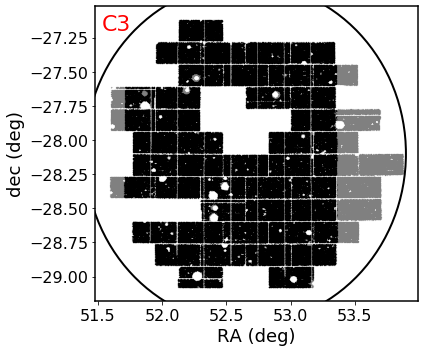

In [82]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
plt.scatter(df_phot['RA'],df_phot['DEC'],s=0.01,c='grey',label='SN-C3')
plt.scatter(df_phot['RA'][df_phot['knn']>0.0],df_phot['DEC'][df_phot['knn']>0.0],s=0.01,c='k',label='NIR phot')

circle1 = plt.Circle((52.6484, -28.1), 2.5/2, color='k', fill=False, lw=2)
ax.add_artist(circle1)

ax.text(0.02, 0.92, 'C3', color='r', fontsize=22, transform=ax.transAxes)

ax.set_xlabel('RA (deg)', fontsize=18)
ax.set_ylabel('dec (deg)', fontsize=18)
ax.tick_params('both', labelsize=16)
fig.tight_layout()

fig.tight_layout()
fig.savefig('figures/c3.png', dpi=300)

In [55]:
print(np.min(df_phot['RA']),np.max(df_phot['RA']))
print(np.min(df_phot['DEC']),np.max(df_phot['DEC']))

51.592973 53.875059
-29.079275 -27.119663


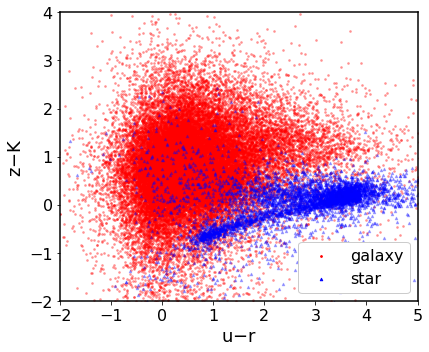

In [104]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
y = df_phot['MAG_Z']-df_phot['MAG_KS']
x = df_phot['MAG_U']-df_phot['MAG_R']
#plt.scatter(x,y,c='b',s=1)
ax.scatter(x[df_phot['knn']==1.0][::10],y[df_phot['knn']==1.0][::10],c='r', s=3, alpha=0.3, label='galaxy')
ax.scatter(x[df_phot['knn']==2.0][::2],y[df_phot['knn']==2.0][::2],c='b', s=6, alpha=0.3, marker='^', label='star')
ax.set_ylabel(r'z$-$K',fontsize=18)
ax.set_xlabel(r'u$-$r',fontsize=18)
ax.set_xlim(-2,5)
ax.set_ylim(-2,4)
ax.tick_params('both', labelsize=16)
legend = ax.legend(fontsize=16, framealpha=1, loc=4)
for lh in legend.legendHandles:
    lh.set_alpha(1)
fig.tight_layout()
fig.savefig('figures/stargalaxy.pdf', dpi=300)

### Spread_model cut

To err on the side of caution, this selection should give a very pure sample of unresolved sources (if in doubt, use difference imaging).

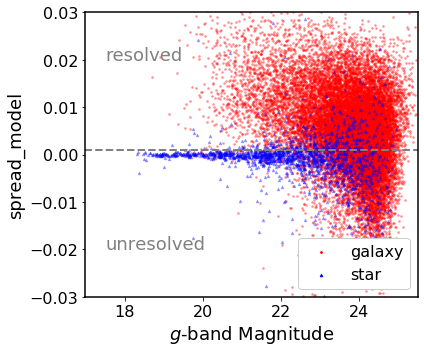

In [105]:
spread_model_cut = 0.001
# Get matches
coord_knn = SkyCoord(df_phot['RA'][df_phot['knn']>0.0], df_phot['DEC'][df_phot['knn']>0.0], unit=u.deg)
coord_psf = SkyCoord(df_lc_psf['ra'], df_lc_psf['dec'], unit=u.deg)
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_knn)
match = d2d < 0.5*u.arcsec

# Plot
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
mag_psf = 22.5 -2.5*np.log10(df_lc_psf['flux_psf'])
# Colors
classification = df_phot['knn'][df_phot['knn']>0.0].values[idx[match]]
x = mag_psf[match][classification==1][::1000]
y = df_lc_psf['spread_model'][match][classification==1][::1000]
ax.scatter(x, y, c='r', s=3, alpha=0.3, label='galaxy')
x = mag_psf[match][classification==2][::1000]
y = df_lc_psf['spread_model'][match][classification==2][::1000]
ax.scatter(x, y, c='b', s=6, alpha=0.3, marker='^', label='star')

# Plot
ax.set_ylabel(r'spread_model', fontsize=18)
ax.set_xlabel('$g$-band Magnitude', fontsize=18)
ax.tick_params('both',labelsize=16)
ax.hlines(spread_model_cut,14,26, color='grey', lw=2, linestyle='dashed')
ax.set_ylim(-0.03,0.03)
ax.set_xlim(17,25.5)
ax.text(17.5, 0.02, 'resolved', fontsize=18, color='grey')
ax.text(17.5, -0.02, 'unresolved', fontsize=18, color='grey')

legend = ax.legend(fontsize=16, framealpha=1, loc=4)
for lh in legend.legendHandles:
    lh.set_alpha(1)

fig.tight_layout()
fig.savefig('figures/spreadmodel.pdf', dpi=300)

### Define Selection functions

In [22]:
def reject_outliers(mjd, mag, magerr, m=3.0, merr=5.0):
    # Magnitude outliers
    d = np.abs(mag - np.nanmedian(mag))
    mdev = np.nanmedian(d)
    s = d/mdev if mdev else 0.0
    mask_mag = (s<m)
    # Magnitude error outliers (SNR cut)
    mdev = np.nanmedian(magerr)
    s = magerr/mdev if mdev else 0.0
    mask_magerr = (s<merr)
    mask = mask_mag & mask_magerr
    return mjd[mask], mag[mask], magerr[mask]

def reject_outliers2(dfi, window=180, m=3.0):
    #mjd, mag, magerr, m=3.0, merr=5.0):
    dfi = pd.DataFrame(mjd, mag, magerr, names=['mjd','mag','magerr'])
    med = dfi['mjd'].rolling(window).median()
    s = dfi['mjd'].rolling(window).std()
    dfi_rej = dfi[(dfi.mag < med+m*s) & (dfi.mag > med-m*s)]
    return df_rej['mjd'].values, df_rej['mag'].values, df_rej['magerr'].values

def plot_lc(mjd, mag, magerr, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4))
    else:
        fig = plt.gcf()
    ax.errorbar(mjd,mag,yerr=magerr,c='k',fmt='.',alpha=0.75,elinewidth=1)
    ax.set_xlabel('Time (MJD)',fontsize=18)
    ax.set_ylabel(r'Magnitude $g$',fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_ylim(np.nanmax(mag)+.1, np.nanmin(mag)-.1)
    fig.tight_layout()
    return ax

def make_lc_psf(dfi, min_epochs=50, correct_err=False):
    # Select candidates
    resolved = np.nanmedian(dfi['spread_model'].values) > spread_model_cut
    if not resolved:
        # Get PSF light curve
        mjd_psf = dfi['mjd_obs'].values
        flux = dfi['flux_psf'].values
        fluxerr = dfi['fluxerr_psf'].values
        # Convert to mag
        mag_psf = 22.5 -2.5*np.log10(flux)
        magerr_psf = 2.5/np.log(10)*fluxerr/flux
        med_mag_psf = np.nanmedian(mag_psf)
        # Bad flux
        mask = np.isfinite(mag_psf) & (mag_psf>0)
        mjd_psf = mjd_psf[mask]
        mag_psf = mag_psf[mask]
        magerr_psf = magerr_psf[mask]
        # Corrected error adds in quadrature with systematic scatter at the median magnitude
        if correct_err:
            magerr_psf = np.sqrt(magerr_psf**2 + poly.polyval(med_mag_psf, coefs_psf)**2)
        # Outlier rejection
        mjd_psf, mag_psf, magerr_psf = reject_outliers(mjd_psf, mag_psf, magerr_psf)
        n_epochs_psf = len(mjd_psf)
        # Magnitude and number of epochs limit
        if n_epochs_psf > min_epochs:
            return str(dfi['ra_as'].values[0])+' '+str(dfi['dec_as'].values[0]), dfi['ra'].values[0], dfi['dec'].values[0], mjd_psf, mag_psf, magerr_psf

def make_lc_dia(dfi, min_epochs=50, correct_err=False):
    # Select candidates
    # Get DIA light curve
    mjd_dia = dfi['mjd_obs'].values
    flux = dfi['flux5'].values
    fluxerr = dfi['fluxerr5'].values
    # Convert to mag
    mag_dia = 30.753 -2.5*np.log10(flux) # Use arbitrary dia zp
    magerr_dia = 2.5/np.log(10)*fluxerr/flux
    med_mag_dia = np.nanmedian(mag_dia)
    # Bad flux
    mask = np.isfinite(mag_dia) & (mag_dia>0)
    mjd_dia = mjd_dia[mask]
    mag_dia = mag_dia[mask]
    magerr_dia = magerr_dia[mask]
    # Corrected error adds in quadrature with systematic scatter at the median magnitude
    if correct_err:
        magerr_dia = np.sqrt(magerr_dia**2 + poly.polyval(med_mag_dia, coefs_dia)**2)
    # Outlier rejection
    mjd_dia, mag_dia, magerr_dia = reject_outliers(mjd_dia, mag_dia, magerr_dia)
    n_epochs_dia = len(mjd_dia)
    # Magnitude and number of epochs limit
    if n_epochs_dia > min_epochs:
        return str(dfi['ra_as'].values[0])+' '+str(dfi['dec_as'].values[0]), dfi['ra'].values[0], dfi['dec'].values[0], mjd_dia, mag_dia, magerr_dia

def select_flare(dfi, plot=False):
    # Select candidates
    mjd = dfi['mjd']
    mag = dfi['mag']
    magerr = dfi['magerr']
    med_mag = np.nanmedian(mag)
    amp = np.nanmedian(mag) - np.nanmin(mag)
    #good, avg, rms, sigavg, sigrms = myvarlc(mag,magerr)
    rms = np.nanstd(mag)
    num_flare = len(mag[(np.nanmedian(mag)-mag)>5*rms])
    if amp > 5*rms and num_flare > 3:
        ax = plot_lc(mjd, mag, magerr)
        plt.show()
    return
    
def select(dfi, plot=False):
    # Get PSF light curve
    mjd = dfi['mjd']
    mag = dfi['mag']
    magerr = dfi['magerr']
    med_mag = np.nanmedian(mag)
    good, avg, rms, sigavg, sigrms = myvarlc(mag,magerr)
    snr = rms/sigrms
    if snr > 3 and rms > 0.01 and plot:
        #print(dfi['ra'],dfi['dec'])
        ax = plot_lc(mjd, mag, magerr)
        ax.text(0.1,0.9,'RMS=%f' % rms, transform=ax.transAxes)
        ax.text(0.1,0.85,'SNR=%f' % snr, transform=ax.transAxes)
        plt.show()
    return snr, rms, np.nanstd(mag), med_mag

def select_qso_fit(dfi, plot=False):
    # Get PSF light curve
    mjd = dfi['mjd']
    mag = dfi['mag']
    magerr = dfi['magerr']
    med_mag = np.nanmedian(mag)
    out = qso_fit(mjd,mag,magerr,filter='g')
    svar = out['signif_vary']
    sqso = out['signif_qso']
    if svar > 3 and sqso > 3 and plot:
        #print(dfi['ra'],dfi['dec'])
        ax = plot_lc(mjd, mag, magerr)
        ax.text(0.1,0.9,'RMS=%f' % rms, transform=ax.transAxes)
        ax.text(0.1,0.85,'SNR=%f' % snr, transform=ax.transAxes)
        plt.show()
    return svar, sqso

### Make Light Curves

Matches rows in catalog to make light curves. Does cuts on spread_model, mag > 17, and at least 25 epochs. 

In [19]:
# WARNING

# PSF light curves
selected = df_lc_psf.groupby(['ra_as', 'dec_as']).apply(make_lc_psf)
selected = [row for row in selected.to_numpy() if row is not None]
light_curves_psf = pd.DataFrame(selected, columns=['name','ra','dec','mjd','mag','magerr'])
# DIA light curves
selected = df_lc_dia.groupby(['ra_as', 'dec_as']).apply(make_lc_dia)
selected = [row for row in selected.to_numpy() if row is not None]
light_curves_dia = pd.DataFrame(selected, columns=['name','ra','dec','mjd','mag','magerr'])
# Remove DIA light curves if there is a PSF light curve (source is unresolved)
light_curves_dia = light_curves_dia[~light_curves_dia['name'].isin(light_curves_psf['name'])].dropna()

KeyboardInterrupt: 

### Variability Selection

In [16]:
var_columns = ['snr','rms','std','med_mag']
# PSF selection
selected = light_curves_psf.apply(select, axis=1)
selected = [row for row in selected.to_numpy() if row is not None]
var_psf = pd.DataFrame(selected, columns=var_columns)
# DIA selection
selected = light_curves_dia.apply(select, axis=1)
selected = [row for row in selected.to_numpy() if row is not None]
var_dia = pd.DataFrame(selected, columns=var_columns)

### Bootstrap error bars

Do separately for PSF and DIA

[0.00588021 0.00426806 0.00394592 0.00399866 0.00445532 0.0047784
 0.00522526 0.00597235 0.00696954 0.00860508 0.01053633 0.01344554
 0.0182177  0.02520943 0.03683279 0.05351718 0.07838384 0.1117252 ]
[0.00378544 0.00334664 0.00384923 0.00469398 0.00529262 0.00688395
 0.00936099 0.01355507 0.02013635 0.03076144 0.04759984 0.07416072
 0.1137885  0.17157251 0.23829055 0.35690671 0.93488676 0.8899268 ]


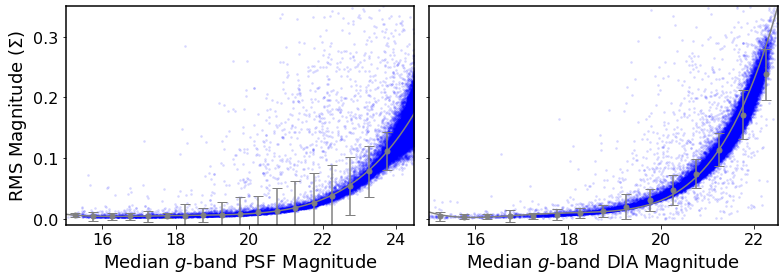

In [19]:
bin_edges = np.arange(15.0,24.25,0.5)
fig,ax = plt.subplots(1,2,figsize=(11,4), sharey=True)
bin_std_psf, bin_edges, binnumber = st.binned_statistic(var_psf['med_mag'],var_psf['std'],statistic='std',bins=bin_edges)
bin_med_psf, bin_edges, binnumber = st.binned_statistic(var_psf['med_mag'],var_psf['std'],statistic='median',bins=bin_edges)
bin_std_dia, bin_edges, binnumber = st.binned_statistic(var_dia['med_mag'],var_dia['std'],statistic='std',bins=bin_edges)
bin_med_dia, bin_edges, binnumber = st.binned_statistic(var_dia['med_mag'],var_dia['std'],statistic='median',bins=bin_edges)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

print(bin_med_psf)
print(bin_med_dia)

# Fit fourth-order polynomial (Sesar et al 2007)
x_eval = np.linspace(14,25,100)
coefs_psf = poly.polyfit(bin_centers, bin_med_psf, 4, w=1/bin_std_psf)
ffit_psf = poly.polyval(x_eval, coefs_psf)
coefs_dia = poly.polyfit(bin_centers, bin_med_dia, 4, w=1/bin_std_dia)
ffit_dia = poly.polyval(x_eval, coefs_dia)

# Save
np.save('coefs_psf',coefs_psf)
np.save('coefs_dia',coefs_dia)

# Plot
ax[0].scatter(var_psf['med_mag'],var_psf['std'],c='b', s=3, alpha=0.1)
ax[0].errorbar(bin_centers,bin_med_psf,yerr=bin_std_psf,c='grey',fmt='.',capsize=5, ms=10)
ax[0].plot(x_eval, ffit_psf,c='grey', lw=1.5)
ax[1].scatter(var_dia['med_mag'],var_dia['std'],c='b', s=3, alpha=0.1)
ax[1].errorbar(bin_centers,bin_med_dia,yerr=bin_std_dia,c='grey',fmt='.',capsize=5, ms=10)
ax[1].plot(x_eval, ffit_dia,c='grey', lw=1.5)

ax[0].set_ylim(-0.01,0.35)
ax[0].set_xlim(15,24.5)
ax[1].set_xlim(15,22.5)
ax[0].set_ylabel(r'RMS Magnitude ($\Sigma$)', fontsize=18)
ax[0].set_xlabel('Median $g$-band PSF Magnitude', fontsize=18)
ax[1].set_xlabel('Median $g$-band DIA Magnitude', fontsize=18)
ax[0].tick_params('both',labelsize=16)
ax[1].tick_params('both',labelsize=16)
fig.tight_layout()
fig.savefig('figures/correction.pdf', dpi=300)

### Re-compute selection with corrected errors

Corrected errors:

$$ \sigma' = \sqrt{\sigma^2 + \left<\xi(m)\right>^2}$$

In [9]:
# PSF light curves
selected = df_lc_psf.groupby(['ra_as', 'dec_as']).apply(make_lc_psf, correct_err=True)
selected = [row for row in selected.to_numpy() if row is not None]
light_curves_psf = pd.DataFrame(selected, columns=['name','ra','dec','mjd','mag','magerr'])
# DIA light curves
selected = df_lc_dia.groupby(['ra_as', 'dec_as']).apply(make_lc_dia, correct_err=True)
selected = [row for row in selected.to_numpy() if row is not None]
light_curves_dia = pd.DataFrame(selected, columns=['name','ra','dec','mjd','mag','magerr'])
# Remove DIA light curves if there is a PSF light curve (source is unresolved)
light_curves_dia = light_curves_dia[~light_curves_dia['name'].isin(light_curves_psf['name'])].dropna()

NameError: name 'df_lc_psf' is not defined

### Checkpoint and final selection (with corrected light curves)

In [8]:
# Save light curves 
light_curves_dia.to_pickle('light_curves_dia')
light_curves_psf.to_pickle('light_curves_psf')

NameError: name 'light_curves_dia' is not defined

In [84]:
# Load light curves
light_curves_psf = pd.read_pickle('light_curves_psf')
light_curves_dia = pd.read_pickle('light_curves_dia')

In [85]:
# Get coordinates
coord_psf = SkyCoord(light_curves_psf['ra'], light_curves_psf['dec'], unit=u.deg)
coord_dia = SkyCoord(light_curves_dia['ra'], light_curves_dia['dec'], unit=u.deg)

In [86]:
# MLE Estimator
var_columns = ['snr','rms','std','med_mag']
# Select variable sources on new light curves
selected = light_curves_psf.apply(select, axis=1, plot=False)
selected = [row for row in selected.to_numpy()]
var_psf = pd.DataFrame(selected, columns=var_columns)
# Select variable sources on new light curves
selected = light_curves_dia.apply(select, axis=1, plot=False)
selected = [row for row in selected.to_numpy()]
var_dia = pd.DataFrame(selected, columns=var_columns)

In [87]:
# QSO_FIT
var_columns = ['var','qso']
# Select variable sources on new light curves
selected = light_curves_psf.apply(select_qso_fit, axis=1, plot=False)
selected = [row for row in selected.to_numpy()]
var_psf_qso = pd.DataFrame(selected, columns=var_columns)
# Select variable sources on new light curves
selected = light_curves_dia.apply(select_qso_fit, axis=1, plot=False)
selected = [row for row in selected.to_numpy()]
var_dia_qso = pd.DataFrame(selected, columns=var_columns)

In [88]:
# Get rms versus magnitude
coefs_psf = np.load('coefs_psf.npy')
coefs_dia = np.load('coefs_dia.npy')
eta_psf = poly.polyval(var_psf['med_mag'].values, coefs_psf)
eta_dia = poly.polyval(var_dia['med_mag'].values, coefs_dia)

### Example DIA light curve

51.59918 -28.558673


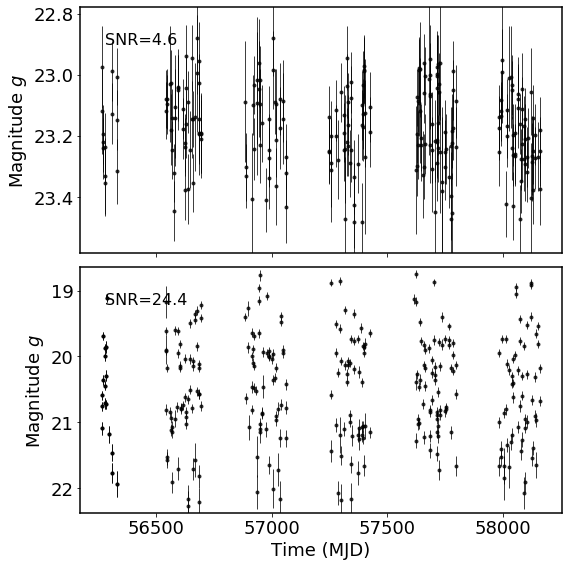

51.600389 -28.279784999999997


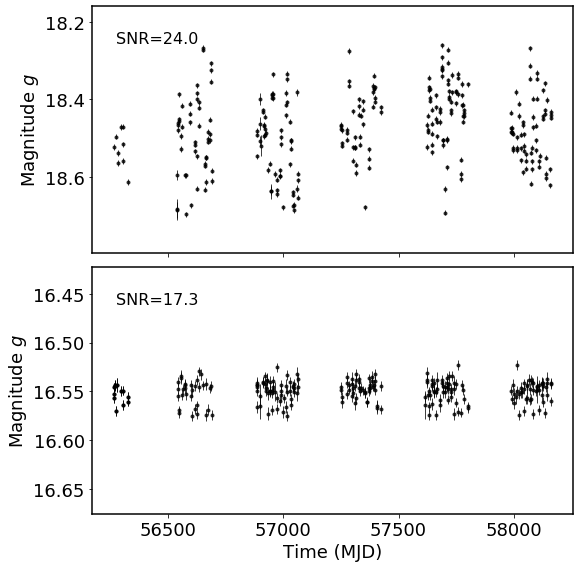

51.605035 -27.758496


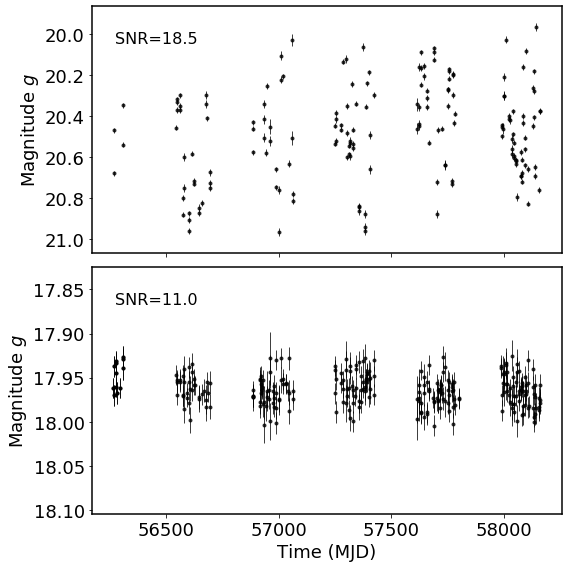

51.606045 -27.733158000000003


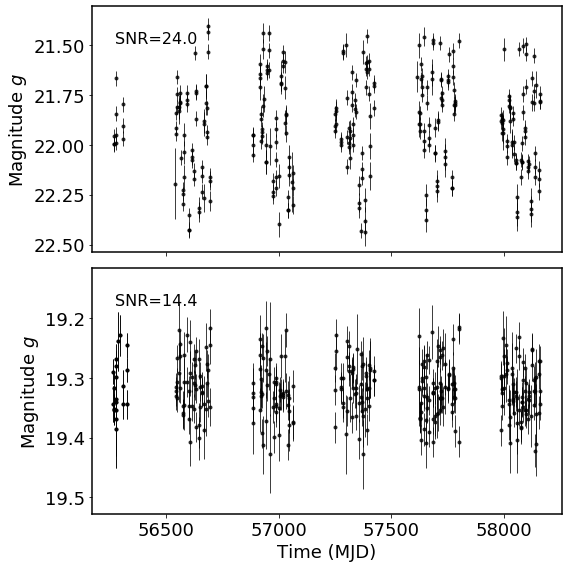

51.609134000000005 -28.381512


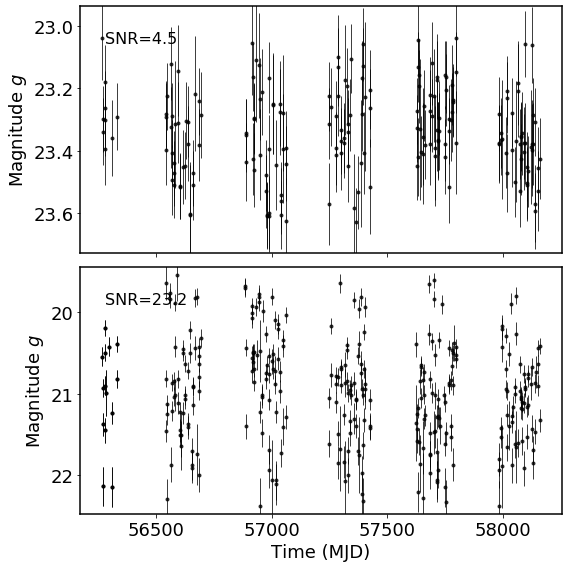

51.650161 -28.562301


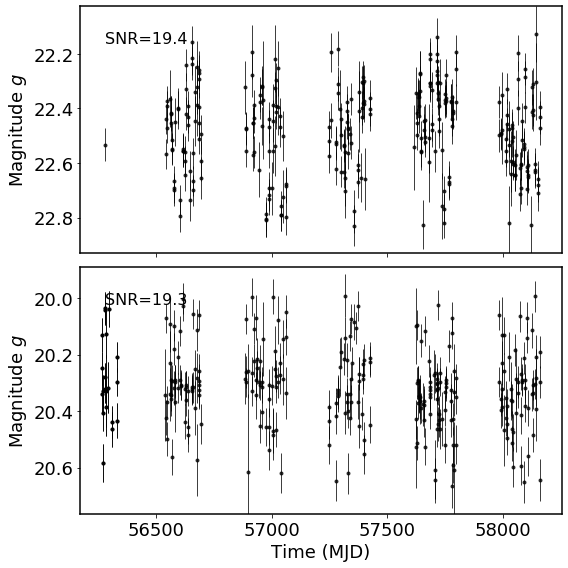

51.737844 -28.443904999999997


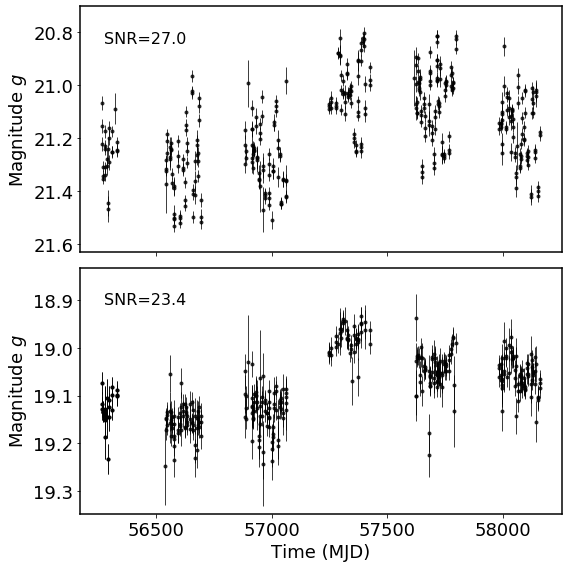

KeyboardInterrupt: 

In [33]:
done=False

def plot_ex_dia(dfi, min_epochs=50, correct_err=False):
    if done: return
    # Select candidates
    resolved = np.nanmedian(dfi['spread_model'].values) > 10*spread_model_cut
    if resolved:        
        # Get PSF light curve
        mjd_psf = dfi['mjd_obs'].values
        flux = dfi['flux_psf'].values
        fluxerr = dfi['fluxerr_psf'].values
        # Convert to mag
        mag_psf = 22.5 -2.5*np.log10(flux)
        magerr_psf = 2.5/np.log(10)*fluxerr/flux
        med_mag_psf = np.nanmedian(mag_psf)
        # Bad flux
        mask = np.isfinite(mag_psf) & (mag_psf>0)
        mjd_psf = mjd_psf[mask]
        mag_psf = mag_psf[mask]
        magerr_psf = magerr_psf[mask]
        # Corrected error adds in quadrature with systematic scatter at the median magnitude
        if correct_err:
            magerr_psf = np.sqrt(magerr_psf**2 + poly.polyval(med_mag_psf, coefs_psf)**2)
        # Outlier rejection
        mjd_psf, mag_psf, magerr_psf = reject_outliers(mjd_psf, mag_psf, magerr_psf)
        n_epochs_psf = len(mjd_psf)
        # Magnitude and number of epochs limit
        if n_epochs_psf > min_epochs:
            # Get DIA light curve
            ra_as = dfi['ra_as'].values[0]
            dec_as = dfi['dec_as'].values[0]
            dfi = df_lc_dia[(df_lc_dia.ra_as==ra_as) & (df_lc_dia.dec_as==dec_as)]
            mjd_dia = dfi['mjd_obs'].values
            flux = dfi['flux5'].values
            fluxerr = dfi['fluxerr5'].values
            # Convert to mag
            mag_dia = 30.753 -2.5*np.log10(flux) # Use arbitrary dia zp
            magerr_dia = 2.5/np.log(10)*fluxerr/flux
            med_mag_dia = np.nanmedian(mag_dia)
            # Bad flux
            mask = np.isfinite(mag_dia) & (mag_dia>0)
            mjd_dia = mjd_dia[mask]
            mag_dia = mag_dia[mask]
            magerr_dia = magerr_dia[mask]
            # Corrected error adds in quadrature with systematic scatter at the median magnitude
            if correct_err:
                magerr_dia = np.sqrt(magerr_dia**2 + poly.polyval(med_mag_dia, coefs_dia)**2)
            # Outlier rejection
            mjd_dia, mag_dia, magerr_dia = reject_outliers(mjd_dia, mag_dia, magerr_dia)
            n_epochs_dia = len(mjd_dia)
            # Magnitude and number of epochs limit
            if n_epochs_dia > min_epochs:
                good, avg, rms, sigavg, sigrms = myvarlc(mag_dia, magerr_dia)
                snr_dia = rms/sigrms
                good, avg, rms, sigavg, sigrms = myvarlc(mag_psf, magerr_psf)
                snr_psf = rms/sigrms
                if snr_dia > 10 and rms > 0.05:
                    print(dfi['ra'].values[0],dfi['dec'].values[0])
                    # PSF
                    fig, ax = plt.subplots(2,1, figsize=(8,4*2), sharex=True)
                    ax[0].errorbar(mjd_psf, mag_psf, yerr=magerr_psf,c='k',fmt='.',alpha=0.75,elinewidth=1)
                    ax[0].text(0.05,0.85,'SNR=%.1f' % snr_psf, transform=ax[0].transAxes, fontsize=16)
                    ax[0].set_ylabel(r'Magnitude $g$',fontsize=18)
                    ax[0].tick_params(labelsize=18)
                    ax[0].set_ylim(np.nanmax(mag_psf)+.1, np.nanmin(mag_psf)-.1)
                    # DIA
                    ax[1].errorbar(mjd_dia, mag_dia, yerr=magerr_dia,c='k',fmt='.',alpha=0.75,elinewidth=1)
                    ax[1].text(0.05,0.85,'SNR=%.1f' % snr_dia, transform=ax[1].transAxes, fontsize=16)
                    ax[1].set_xlabel('Time (MJD)',fontsize=18)
                    ax[1].set_ylabel(r'Magnitude $g$',fontsize=18)
                    ax[1].tick_params(labelsize=18)
                    ax[1].set_ylim(np.nanmax(mag_dia)+.1, np.nanmin(mag_dia)-.1)
                    fig.tight_layout()
                    fig.savefig('figures/dia_example.pdf', dpi=300)
                    plt.show()
                    #done = True
                    
df_lc_psf.groupby(['ra_as', 'dec_as']).apply(plot_ex_dia, correct_err=True)

### Selection Versus Stellar Mass

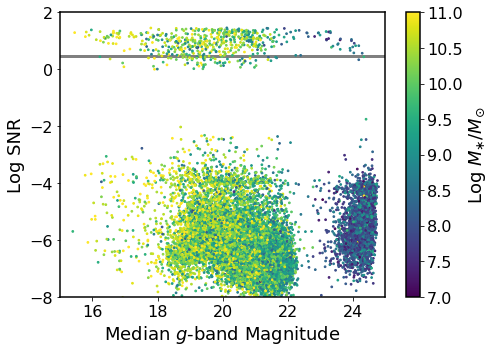

In [66]:
fig,ax = plt.subplots(1,1,figsize=(7,5), sharey=True)
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_palmese)
match = d2d < 0.5*u.arcsec

mask = (np.log10(var_psf['snr']) < -.999) | (np.log10(var_psf['snr']) > 0.001)
c = np.clip(df_palmese['MASS_BEST'][idx[match&mask]],5,13)
ax.scatter(var_psf['med_mag'][match&mask], np.log10(var_psf['snr'])[match&mask], s=3, c=c)

# DIA
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_palmese)
match = d2d < 0.5*u.arcsec

mask = (np.log10(var_dia['snr']) < -.999) | (np.log10(var_dia['snr']) > 0.001)
c = np.clip(df_palmese['MASS_BEST'][idx[match&mask]],7,11)
im = ax.scatter(var_dia['med_mag'][match&mask], np.log10(var_dia['snr'])[match&mask], s=3, c=c)

ax.hlines(np.log10(3),14,26, color='grey', lw=3, zorder=-1)
ax.tick_params('both',labelsize=16)

ax.set_xlim(15, 25)
ax.set_ylim(-8, 2)
ax.set_xlabel(r'Median $g$-band Magnitude',fontsize=18)
ax.set_ylabel(r'Log SNR',fontsize=18)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r'Log $M_{\ast}/M_{\odot}$', fontsize=18)
cbar.ax.tick_params('both',labelsize=16)

fig.tight_layout()
fig.savefig('figures/snr.pdf')

### Save catalog of variable AGN with stellar masses

In [61]:
# Save catalog
print(len(var_psf[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)]), len(var_psf))
print(len(var_dia[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)]), len(var_dia))

805 50330
311 42239


In [62]:
light_curves_dia = light_curves_dia.reset_index()

In [83]:
# Save catalog
mask_var_psf = (var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)
mask_var_dia = (var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)

mask_var_psf_qso = (var_psf_qso['qso']>3) & (var_psf_qso['var']>3)
mask_var_dia_qso = (var_dia_qso['qso']>3) & (var_dia_qso['var']>3)

# Match MLE-selected  
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_palmese)
desXpalmese_psf = d2d < 0.5*u.arcsec
palmeseXdes_var_psf = idx[mask_var_psf & desXpalmese_psf]

idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_palmese)
desXpalmese_dia = d2d < 0.5*u.arcsec
palmeseXdes_var_dia = idx[mask_var_dia & desXpalmese_dia]

# Match QSO_FIT-selected
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_palmese)
desXpalmese_psf_qso = d2d < 0.5*u.arcsec
palmeseXdes_var_psf_qso = idx[mask_var_psf_qso & desXpalmese_psf_qso]

idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_palmese)
desXpalmese_dia_qso = d2d < 0.5*u.arcsec
palmeseXdes_var_dia_qso = idx[mask_var_dia_qso & desXpalmese_dia_qso]

# Select
lc_psf_var = light_curves_psf[mask_var_psf & desXpalmese_psf]
ra_psf_var = coord_psf.ra.deg[mask_var_psf & desXpalmese_psf]
dec_psf_var = coord_psf.dec.deg[mask_var_psf & desXpalmese_psf]
mass_psf_var = df_palmese['MASS_BEST'][palmeseXdes_var_psf]
mag_psf_var = var_psf['med_mag'].values[mask_var_psf & desXpalmese_psf]

lc_dia_var = light_curves_dia[mask_var_dia & desXpalmese_dia]
ra_dia_var = coord_dia.ra.deg[mask_var_dia & desXpalmese_dia]
dec_dia_var = coord_dia.dec.deg[mask_var_dia & desXpalmese_dia]
mass_dia_var = df_palmese['MASS_BEST'][palmeseXdes_var_dia]
mag_dia_var = var_dia['med_mag'].values[mask_var_dia & desXpalmese_dia]

#QSO-FIT
mass_psf_var_qso = df_palmese['MASS_BEST'][palmeseXdes_var_psf_qso]
mag_psf_var_qso = var_psf['med_mag'].values[mask_var_psf_qso & desXpalmese_psf_qso]

mass_dia_var_qso = df_palmese['MASS_BEST'][palmeseXdes_var_dia_qso]
mag_dia_var_qso = var_dia['med_mag'].values[mask_var_dia_qso & desXpalmese_dia_qso]


print(len(mass_psf_var[mass_psf_var<10]))
print(len(mass_dia_var[mass_dia_var<10]))

# Save data
lc_psf_var.to_pickle('light_curves_var_psf')
np.save('cat_var_psf',[ra_psf_var,dec_psf_var,mass_psf_var])

lc_dia_var.to_pickle('light_curves_var_dia')
np.save('cat_var_dia',[ra_dia_var,dec_dia_var,mass_dia_var])

# Make catalog

ValueError: operands could not be broadcast together with shapes (50330,) (50688239,) 

Make useful histograms

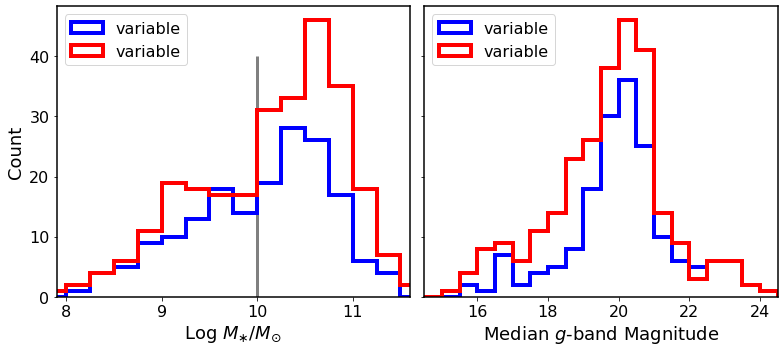

In [57]:
# Plot histogram of mass
fig,ax = plt.subplots(1,2,figsize=(11,5), sharey=True)
# Left
bins = np.arange(7,13,0.25)
#ax[0].hist(df_palmese['MASS_BEST'],color='k',fill=None,histtype='step',linestyle='dashed',lw=4,bins=bins,normed=True,label='all C3')
ax[0].hist(np.concatenate([mass_dia_var.values,mass_psf_var.values]),color='b',fill=None,histtype='step',lw=4,bins=bins,normed=False,label='variable')
ax[0].hist(np.concatenate([mass_dia_var_qso.values,mass_psf_var_qso.values]),color='r',fill=None,histtype='step',lw=4,bins=bins,normed=False,label='variable')

ax[0].vlines(10.0,0,40, color='grey', lw=3, zorder=-1)
ax[0].tick_params('both',labelsize=16)
ax[0].set_xlim(7.9, 11.6)
#ax[0].set_ylim(0, 0.7)
ax[0].set_xlabel(r'Log $M_{\ast}/M_{\odot}$', fontsize=18)
ax[0].set_ylabel('Count',fontsize=18)
ax[0].legend(fontsize=16, loc=2)
# Right
bins = np.arange(12,25,0.5)
#ax[1].hist(np.concatenate([var_psf['med_mag'].values,var_dia['med_mag'].values]),color='k',fill=None,histtype='step',linestyle='dashed',lw=4,bins=bins,normed=True,label='all C3')
ax[1].hist(np.concatenate([mag_psf_var,mag_dia_var]),color='b',fill=None,histtype='step',lw=4,bins=bins,normed=False,label='variable')
ax[1].hist(np.concatenate([mag_psf_var_qso,mag_dia_var_qso]),color='r',fill=None,histtype='step',lw=4,bins=bins,normed=False,label='variable')

ax[1].vlines(10.0,0,40, color='grey', lw=3, zorder=-1)
ax[1].tick_params('both',labelsize=16)
ax[1].set_xlim(14.5, 24.5)
#ax[1].set_ylim(0, 0.7)
ax[1].set_xlabel(r'Median $g$-band Magnitude',fontsize=18)
ax[1].legend(fontsize=16, loc=2)

fig.tight_layout()
fig.savefig('figures/dists.pdf')

### Get Aperture light curves at OzDES MJD

Get C3 g-band aperture light curves:

Y1-Y6:

`with SNVAR_TEMP_1 as (select CATALOGNAME, MAG_ZERO, SIGMA_MAG_ZERO, MAG_ONE, SIGMA_MAG_ONE, MJD_OBS from  Y6A1_EXPOSURE join Y6A1_ZEROPOINT on Y6A1_EXPOSURE.expnum = Y6A1_ZEROPOINT.expnum where field like 'SN-C3' and Y6A1_ZEROPOINT.flag < 16 and Y6A1_ZEROPOINT.source='FGCM' and Y6A1_ZEROPOINT.version='y6a1_v2.1' and MJD_OBS>56400 and EXPTIME > 30 order by CATALOGNAME ) select RA, DEC, MJD_OBS, Y6A1_FINALCUT_OBJECT.FLUX_APER_4*POWER(10,-0.4*MAG_ZERO+9) as FLUX_APER_4, SQRT(POWER(1.09*SIGMA_MAG_ZERO*Y6A1_FINALCUT_OBJECT.FLUX_APER_4, 2) + POWER(Y6A1_FINALCUT_OBJECT.FLUXERR_APER_4, 2))*POWER(10,-0.4*MAG_ZERO+9) as FLUXERR_APER_4, SPREAD_MODEL, BAND from  Y6A1_FINALCUT_OBJECT, SNVAR_TEMP_1 where CATALOGNAME = FILENAME and BAND='g' order by DEC, RA; > /data/des80.a/data/cburke/y6a1_c3_g_aper_light_curves.csv`

SV:

`with SNVAR_TEMP_1 as (select CATALOGNAME, MAG_ZERO, SIGMA_MAG_ZERO, MAG_ONE, SIGMA_MAG_ONE, MJD_OBS from  Y4A1_EXPOSURE join Y4A1_ZEROPOINT on Y4A1_EXPOSURE.expnum = Y4A1_ZEROPOINT.expnum where field like 'SN-C3' and Y4A1_ZEROPOINT.flag < 16 and Y4A1_ZEROPOINT.source = 'FGCM' and Y4A1_ZEROPOINT.version='v2.0' and MJD_OBS<56400 and EXPTIME > 30 order by CATALOGNAME ) select RA, DEC, MJD_OBS, Y4A1_FINALCUT_OBJECT.FLUX_APER_4*POWER(10,-0.4*MAG_ZERO+9) as FLUX_APER_4, SQRT(POWER(1.09*SIGMA_MAG_ZERO*Y4A1_FINALCUT_OBJECT.FLUX_APER_4, 2) + POWER(Y4A1_FINALCUT_OBJECT.FLUXERR_APER_4, 2))*POWER(10,-0.4*MAG_ZERO+9) as FLUXERR_APER_4, SPREAD_MODEL, BAND  from Y4A1_FINALCUT_OBJECT, SNVAR_TEMP_1 where CATALOGNAME = FILENAME and BAND='g' order by DEC, RA; > /data/des80.a/data/cburke/sv_c3_g_aper_light_curves.csv`

Variable SNR>3 galaxies with sigma_qso<3:  23
out of variable galaxies:  134


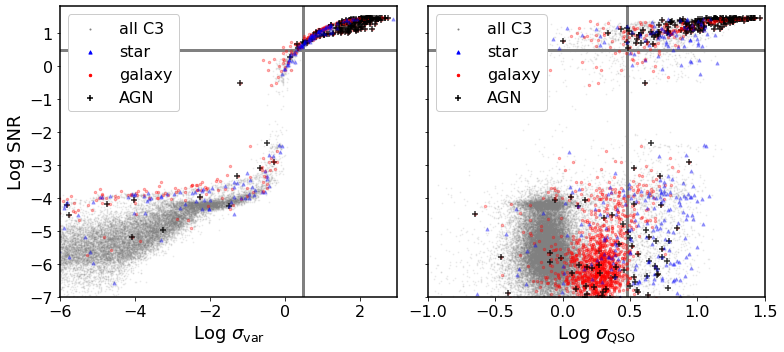

In [45]:
fig,ax = plt.subplots(1,2,figsize=(11,5), sharey=True)

# Mask
mask = (np.log10(var_psf['snr']) > -1) & (np.log10(var_psf_qso['var']) < -3)

x = np.log10(var_psf_qso['var'])[~mask]
y = np.log10(var_psf['snr'])[~mask]
ax[0].scatter(x, y, s=1, c='grey', alpha=0.1, label='all C3', zorder=-3)

# SNR vs. sigma_var
# Star
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
x = np.log10(var_psf_qso['var'])[match&~mask]
y = np.log10(var_psf['snr'])[match&~mask]
ax[0].scatter(x, y, s=10, c='b', alpha=0.3, marker='^', label='star')
# Galaxy 
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
x = np.log10(var_psf_qso['var'])[match&~mask]
y = np.log10(var_psf['snr'])[match&~mask]
ax[0].scatter(x, y, s=6, c='r', alpha=0.3, zorder=-1, label='galaxy')
# AGN
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 0.5*u.arcsec
x = np.log10(var_psf_qso['var'])[match&~mask]
y = np.log10(var_psf['snr'])[match&~mask]
ax[0].scatter(x, y, s=30, c='k', zorder=-1, marker='+', alpha=0.8, label='AGN')
# DIA
# Star
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
mask = (np.log10(var_dia['snr']) > -1) & (np.log10(var_dia_qso['var']) < -3)
x = np.log10(var_dia_qso['var'])[match&~mask]
y = np.log10(var_dia['snr'])[match&~mask]
ax[0].scatter(x, y, s=10, c='b', marker='^', alpha=0.3)
# Galaxy 
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
x = np.log10(var_dia_qso['var'])[match&~mask]
y = np.log10(var_dia['snr'])[match&~mask]
ax[0].scatter(x, y, s=6, c='r', alpha=0.3, zorder=-1)
# AGN
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 0.5*u.arcsec
x = np.log10(var_dia_qso['var'])[match&~mask]
y = np.log10(var_dia['snr'])[match&~mask]
ax[0].scatter(x, y, s=30, c='k', marker='+', alpha=0.8, zorder=-1)

# SNR vs. sigma_qso

mask = (np.log10(var_psf['snr']) > -1) & (np.log10(var_psf_qso['var']) < -3)

x = np.log10(var_psf_qso['qso'])[~mask]
y = np.log10(var_psf['snr'])[~mask]
ax[1].scatter(x, y, s=1, c='grey', alpha=0.1, label='all C3', zorder=-3)

# Star
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
x = np.log10(var_psf_qso['qso'])[match&~mask]
y = np.log10(var_psf['snr'])[match&~mask]
ax[1].scatter(x, y, s=10, c='b', alpha=0.3, marker='^', label='star')
# Galaxy 
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
x = np.log10(var_psf_qso['qso'])[match&~mask]
y = np.log10(var_psf['snr'])[match&~mask]
ax[1].scatter(x, y, s=6, c='r', alpha=0.3, zorder=-1, label='galaxy')
# AGN 
idx,d2d,d3d = coord_psf.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 0.5*u.arcsec
x = np.log10(var_psf_qso['qso'])[match&~mask]
y = np.log10(var_psf['snr'])[match&~mask]
ax[1].scatter(x, y, s=30, c='k', marker='+', zorder=-1, alpha=0.8, label='AGN')
# Star
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
mask = (np.log10(var_dia['snr']) > -1) & (np.log10(var_dia_qso['var']) < -3)
x = np.log10(var_dia_qso['qso'])[match&~mask]
y = np.log10(var_dia['snr'])[match&~mask]
ax[1].scatter(x, y, s=10, c='b', alpha=0.3, marker='^')
# Galaxy 
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
x = np.log10(var_dia_qso['qso'])[match&~mask]
y = np.log10(var_dia['snr'])[match&~mask]
ax[1].scatter(x, y, s=6, c='r', alpha=0.3, zorder=-1)
# AGN 
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 0.5*u.arcsec
x = np.log10(var_dia_qso['qso'])[match&~mask]
y = np.log10(var_dia['snr'])[match&~mask]
ax[1].scatter(x, y, s=30, c='k', marker='+', alpha=0.8, zorder=-1)

# sigma = 3 lines
ax[0].hlines(np.log10(3),-10,10, color='grey', lw=3, zorder=-2)
ax[1].hlines(np.log10(3),-10,10, color='grey', lw=3, zorder=-2)
ax[0].vlines(np.log10(3),-10,10, color='grey', lw=3, zorder=-2)
ax[1].vlines(np.log10(3),-10,10, color='grey', lw=3, zorder=-2)

# How many variable galaxies are have sigma_qso<3
# Galaxy 
idx,d2d,d3d = coord_dia.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
x = var_dia['snr'][match&~mask]
y = var_dia_qso['qso'][match&~mask]
print('Variable SNR>3 galaxies with sigma_qso<3: ', len(x[(x>3) & (y<3)]))
print('out of variable galaxies: ', len(x[(x>3)]))


# Plotting
ax[0].tick_params('both',labelsize=16)
ax[1].tick_params('both',labelsize=16)

ax[0].set_xlim(-6, 3)
ax[1].set_xlim(-1, 1.5)

ax[0].set_ylim(-7, 1.8)
ax[0].set_xlabel(r'Log $\sigma_{\rm var}$',fontsize=18)
ax[1].set_xlabel(r'Log $\sigma_{\rm QSO}$',fontsize=18)

ax[0].set_ylabel('Log SNR',fontsize=18)

fig.tight_layout()

legend = ax[0].legend(fontsize=16, framealpha=1, loc=2)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    
legend = ax[1].legend(fontsize=16, framealpha=1, loc=2)
for lh in legend.legendHandles:
    lh.set_alpha(1)

fig.savefig('figures/qsofit.pdf', dpi=300)

In [31]:
# Clear up some memory
del df_lc_psf
del df_lc_dia

Text(0, 0.5, 'Count')

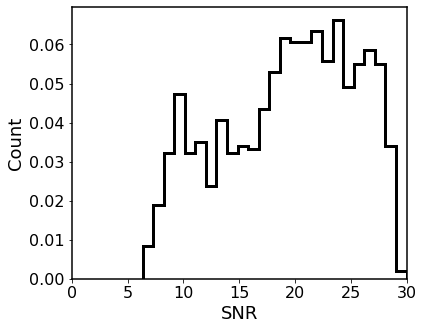

In [71]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
h = np.concatenate([var_psf['snr'][(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)], var_dia['snr'][(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)]])
ax.hist(h,lw=3,fc='none',ec='k',histtype='step',bins=25,density=True);
ax.tick_params('both',labelsize=16)
ax.set_xlim(0, 30)
ax.set_xlabel('SNR',fontsize=18)
ax.set_ylabel('Count',fontsize=18)

### Purity/completeness

How reliable is the kNN classifier?

In [55]:
coord_knn_gal = SkyCoord(df_phot['RA'][df_phot['knn']==1.0], df_phot['DEC'][df_phot['knn']==1.0], unit=u.deg)
coord_knn_star = SkyCoord(df_phot['RA'][df_phot['knn']==2.0], df_phot['DEC'][df_phot['knn']==2.0], unit=u.deg)
coord_knn = SkyCoord(df_phot['RA'][df_phot['knn']>0.0], df_phot['DEC'][df_phot['knn']>0.0], unit=u.deg)

# SNR vs. sigma_var
# Star
idx,d2d,d3d = coord_knn_star.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
TP = len(coord_knn_star[match])
print(TP)
idx,d2d,d3d = coord_knn_star.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
FP = len(coord_knn_star[match])
print(FP)
idx,d2d,d3d = coord_knn_gal.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
FN = len(coord_knn_gal[match])
print(FN)
c = TP/(TP+FN)
p = TP/(TP+FP)
print(p, c)

# Galaxies completeness
idx,d2d,d3d = coord_knn_gal.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
TP = len(coord_knn_gal[match])
print(TP)
idx,d2d,d3d = coord_knn_gal.match_to_catalog_sky(coord_ozdes_star)
match = d2d < 0.5*u.arcsec
FP = len(coord_knn_gal[match])
print(FP)
idx,d2d,d3d = coord_knn_star.match_to_catalog_sky(coord_ozdes_gal)
match = d2d < 0.5*u.arcsec
FN = len(coord_knn_star[match])
print(FN)
c = TP/(TP+FN)
p = TP/(TP+FP)
print(p, c)

30
42
4
0.4166666666666667 0.8823529411764706
1455
4
42
0.9972583961617546 0.9719438877755511


QSO_FIT versus Shen et al. purity/completess

In [91]:
coord_var = concatenate([coord_psf[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)],
                         coord_dia[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)]])
coord_var, idx = remove_duplicates(SkyCoord(coord_var.ra, coord_var.dec))

coord_notvar = concatenate([coord_psf[(var_psf['snr']<3) | (var_psf['rms']<2*eta_psf)],
                         coord_dia[(var_dia['snr']<3) | (var_dia['rms']<2*eta_dia)]])
coord_notvar, idx = remove_duplicates(SkyCoord(coord_notvar.ra, coord_notvar.dec))

# AGN completeness
idx,d2d,d3d = coord_var.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
TP = len(coord_var[match])
print(TP)
idx,d2d,d3d = coord_var.match_to_catalog_sky(coord_ozdes_notagn)
match = d2d < 3*u.arcsec
FP = len(coord_var[match])
print(FP)
idx,d2d,d3d = coord_notvar.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
FN = len(coord_notvar[match])
print(FN)
c = TP/(TP+FN)
p = TP/(TP+FP)
print(p, c)

# QSO_FIT

coord_var = concatenate([coord_psf[(var_psf_qso['var']>3) & (var_psf_qso['qso']>3)],
                         coord_dia[(var_dia_qso['var']>3) & (var_dia_qso['qso']>3)]])
coord_var, idx = remove_duplicates(SkyCoord(coord_var.ra, coord_var.dec))

coord_notvar = concatenate([coord_psf[(var_psf_qso['var']<3) | (var_psf_qso['qso']<3)],
                         coord_dia[(var_dia_qso['var']<3) | (var_dia_qso['qso']<3)]])
coord_notvar, idx = remove_duplicates(SkyCoord(coord_notvar.ra, coord_notvar.dec))

# AGN completeness
idx,d2d,d3d = coord_var.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
TP = len(coord_var[match])
print(TP)
idx,d2d,d3d = coord_var.match_to_catalog_sky(coord_ozdes_notagn)
match = d2d < 3*u.arcsec
FP = len(coord_var[match])
print(FP)
idx,d2d,d3d = coord_notvar.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
FN = len(coord_notvar[match])
print(FN)
c = TP/(TP+FN)
p = TP/(TP+FP)
print(p, c)

167
136
140
0.5511551155115512 0.5439739413680782
175
212
132
0.45219638242894056 0.5700325732899023


In [77]:
coord_var

<SkyCoord (ICRS): (ra, dec) in deg
    [(51.424971, -28.124298), (51.432779, -28.080416),
     (51.435728, -28.104026), ..., (53.763734, -28.118169),
     (53.77901 , -28.202368), (53.856589, -28.24512 )]>

In [51]:
idx,d2d,d3d = coord_psf[(var_psf['rms']>2*eta_psf)].match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
desXozdes_psf_agn = match
ozdesXdes_psf_agn = idx[match]
print('Found %d variable matches to OzDES AGN.' % len(ozdesXdes_psf_agn))
idx,d2d,d3d = coord_dia[(var_dia['rms']>2*eta_dia)].match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
desXozdes_dia_agn = match
ozdesXdes_dia_agn = idx[match]
print('Found %d variable matches to OzDES AGN.' % len(ozdesXdes_dia_agn))
# Plot AGN
fig,ax = plt.subplots(1,1,figsize=(6,5))
x = var_dia['med_mag'][var_dia['rms']>2*eta_dia]
y = np.log10(var_dia['snr'][var_dia['rms']>2*eta_dia])
print(len(x[desXozdes_dia_agn]))
ax.scatter(x[desXozdes_dia_agn], y[desXozdes_dia_agn],s=30,c='r')
x = var_psf['med_mag'][var_psf['rms']>2*eta_psf]
y = np.log10(var_psf['snr'][var_psf['rms']>2*eta_psf])
ax.scatter(x[desXozdes_psf_agn], y[desXozdes_psf_agn],s=3,c='b')
print(len(x[desXozdes_psf_agn]))
# Plot stars

ax.hlines(np.log10(3),14,26, color='grey', lw=3, zorder=-1)
ax.set_xlim(14.5,24)
#ax.set_ylim(-.1,1.5)
ax.set_ylabel(r'Log SNR', fontsize=16)
ax.set_xlabel('$g$ Magnitude', fontsize=16)
ax.tick_params('both',labelsize=16)
fig.tight_layout()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 50688239 but corresponding boolean dimension is 50330

In [34]:
idx,d2d,d3d = coord_psf[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)].match_to_catalog_sky(coord_ozdes)
match = d2d < 3*u.arcsec
desXozdes_psf = match
ozdesXdes_psf = idx[match]
print('Found %d variable matches to OzDES.' % len(ozdesXdes_psf))
idx,d2d,d3d = coord_dia[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)].match_to_catalog_sky(coord_ozdes)
match = d2d < 3*u.arcsec
desXozdes_dia = match
ozdesXdes_dia = idx[match]
print('Found %d variable matches to OzDES.' % len(ozdesXdes_dia))

Found 124 variable matches to OzDES.
Found 72 variable matches to OzDES.


In [50]:
idx,d2d,d3d = coord_psf[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)].match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
desXozdes_psf_agn = match
ozdesXdes_psf_agn = idx[match]
print('Found %d variable matches to OzDES AGN.' % len(ozdesXdes_psf_agn))
idx,d2d,d3d = coord_dia[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)].match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
desXozdes_dia_agn = match
ozdesXdes_dia_agn = idx[match]
print('Found %d variable matches to OzDES AGN.' % len(ozdesXdes_dia_agn))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 50688239 but corresponding boolean dimension is 50330

### Save final catalog for OzDES spectra

In [48]:
def remove_duplicates(coord, r_match=1*u.arcsec):
    idx,d2d,d3d = coord.match_to_catalog_sky(coord)
    match = d2d < r_match
    m = np.zeros_like(idx[match], dtype=bool)
    idx_unique = np.unique(idx[match], return_index=True)[1]
    # can we just return coord[np.unique(idx[match], return_index=True)[1]]
    return coord[idx_unique], idx_unique

In [49]:
# Remove duplicates and save data
coord_psf_var = coord_psf[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
coord_dia_var = coord_dia[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
types = np.concatenate([df_ozdes['object_types'].values[ozdesXdes_psf], df_ozdes['object_types'].values[ozdesXdes_dia]])

coord_var = concatenate([coord_psf_var, coord_dia_var])
coord_var = SkyCoord(coord_var.ra.deg, coord_var.dec.deg, unit=u.deg)
# Remove duplicates
print(len(coord_var))
coord_var, idx = remove_duplicates(coord_var)
data = list(zip(coord_var.ra.deg, coord_var.dec.deg, types))
print(len(coord_var))
np.savetxt('des_c3_varXozdes_v5.dat', data, fmt='%s')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 50688239 but corresponding boolean dimension is 50330

In [ ]:
mjd = light_curves_psf['mjd'].values[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
mag = light_curves_psf['mag'].values[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
magerr = light_curves_psf['magerr'].values[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
rms = var_psf['rms'].values[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
et = eta_psf[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
ty = df_ozdes['object_types'].values[ozdesXdes_psf]
snr = var_psf['snr'].values[(var_psf['snr']>3) & (var_psf['rms']>2*eta_psf)][desXozdes_psf]
for i in range(len(mjd)):
    print(rms[i], np.std(mag[i]), et[i], snr[i])
    print(ty[i])
    plot_lc(mjd[i], mag[i], magerr[i])
    plt.show()
mjd = light_curves_dia['mjd'].values[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
mag = light_curves_dia['mag'].values[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
magerr = light_curves_dia['magerr'].values[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
rms = var_dia['rms'].values[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
et = eta_dia[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
ty = df_ozdes['object_types'].values[desXozdes_dia]
snr = var_psf['snr'].values[(var_dia['snr']>3) & (var_dia['rms']>2*eta_dia)][desXozdes_dia]
for i in range(len(mjd)):
    print(rms[i], np.std(mag[i]), et[i], snr[i])
    print(ty[i])
    plot_lc(mjd[i], mag[i], magerr[i])

### Get interpolated photometry for flux calibration

In [103]:
def get_phot(dfi, mjds_kaiwen, min_epochs=50):
    # Get light curve
    mjd_aper = dfi['mjd_obs'].values
    flux = dfi['flux_aper_4'].values
    fluxerr = dfi['fluxerr_aper_4'].values
    # Convert to mag
    mag_aper = 22.5 -2.5*np.log10(flux)
    magerr_aper = 2.5/np.log(10)*fluxerr/flux
    med_mag_aper = np.nanmedian(mag_aper)
    # Bad flux
    mask = np.isfinite(mag_aper) & (mag_aper>0)
    mjd_aper = mjd_aper[mask]
    mag_aper = mag_aper[mask]
    magerr_aper = magerr_aper[mask]
    # Outlier rejection
    mjd_aper, mag_aper, magerr_aper = reject_outliers(mjd_aper, mag_aper, magerr_aper)
    n_epochs_aper = len(mjd_aper)
    if n_epochs_aper < min_epochs:
        return None
    else:
        plot_lc(mjd_aper, mag_aper, magerr_aper)
        plt.show()
        # Get mag at Kaiwen's MJDs
        mags_kaiwen = np.interp(mjds_kaiwen,mjd_aper,mag_aper)
        return mags_kaiwen

In [133]:
# Read Kaiwen's file
df_kaiwen = pd.read_csv('des_X_ozdes_Colin_v5.dat',names=['ra','dec','type','mjds'],sep='\s+',header=None)
coord_kaiwen = SkyCoord(df_kaiwen['ra'],df_kaiwen['dec'],unit=u.deg)

In [134]:
df_kaiwen

,ra,dec,type,mjds
0,51.543750,-28.242390,Transient,"56917.7049505,56917.734187,56917.7634272"
1,51.550210,-28.233830,"BrightGalaxy,RadioGalaxy_I","56957.6517714,56957.6705925"
2,51.600170,-28.279690,BrightGalaxy,"56957.6517714,56957.6705925"
3,51.647504,-28.405299,SN_host,"57338.6159414,57338.6451783,57338.6744151,5733..."
4,51.652203,-28.013912,SN_host,"57368.5992389,57368.6284758,57368.6577196"
...,...,...,...,...
108,53.359330,-27.974940,"AGN_monitoring,AGN_reverberation","56276.5304276,56276.5603477,56276.5895831,5659..."
109,53.481960,-28.447670,"AGN_monitoring,AGN_reverberation","56274.5977016,56274.626944,56275.6003847,56275..."
110,53.545120,-28.163670,"AGN_monitoring,AGN_reverberation","56595.5955879,56595.6248255,56595.6540645,5659..."
111,53.549420,-27.800580,RadioGalaxy_I,"57012.5270303,57012.5562758,57012.5855135"


In [135]:
# Read light curves
files = glob.glob('/data/des80.a/data/cburke/*_c3_r_aper_light_curves*.csv')
print(files)
df_lc_aper = pd.concat([pd.read_csv(f) for f in files], axis=0, join='inner')
# Lower-case column names
df_lc_aper.columns = df_lc_aper.columns.str.lower()
df_lc_aper['roms'] = [-1]*len(df_lc_aper)
# Combine on RA, dec (effectively match to 0.5 arcsec)
df_lc_aper['ra_as'] = np.around(df_lc_aper['ra']*3600,0) # deg->arcsec
df_lc_aper['dec_as'] = np.around(df_lc_aper['dec']*3600,0)# deg->arcsec
# Create SkyCoord
coord_unique = np.unique(np.array([df_lc_aper['ra_as'],df_lc_aper['dec_as']]).T,axis=0)
coord_des_aper = SkyCoord(coord_unique[:,0],coord_unique[:,1],unit=u.arcsec)

['/data/des80.a/data/cburke/y6a1_c3_r_aper_light_curves_000006.csv', '/data/des80.a/data/cburke/y6a1_c3_r_aper_light_curves_000001.csv', '/data/des80.a/data/cburke/y6a1_c3_r_aper_light_curves_000002.csv', '/data/des80.a/data/cburke/y6a1_c3_r_aper_light_curves_000003.csv', '/data/des80.a/data/cburke/y6a1_c3_r_aper_light_curves_000005.csv', '/data/des80.a/data/cburke/y6a1_c3_r_aper_light_curves_000004.csv']


In [ ]:
# Match to Kaiwen
idx,d2d,d3d = coord_des_aper.match_to_catalog_sky(coord_kaiwen)
match = d2d < 3*u.arcsec

In [137]:
# Get Kaiwen MJDs
mags_kaiwen = []
coord_des_aper_match = coord_des_aper[match]
mjds_kaiwen = df_kaiwen['mjds'].values[idx[match]]
for i in range(len(mjds_kaiwen)):
    mjd_k = np.array(mjds_kaiwen[i].split(','),dtype=np.float)
    c = coord_des_aper_match[i]
    ra_as = c.ra.arcsec
    dec_as = c.dec.arcsec
    dfi = df_lc_aper[(df_lc_aper.ra_as == ra_as) & (df_lc_aper.dec_as == dec_as)]
    #magsi = get_phot(dfi, mjd_k)
    #if magsi is not None:
    #    mags_kaiwen.append(magsi)

In [140]:
len(coord_des_aper_match)

264

In [92]:
for i in range(len(mjds_kaiwen)):
    c = coord_des_aper_match[i]
    print(c.ra.arcsec, c.dec.arcsec)

185435.0 -101431.0
185436.0 -101431.0
185460.0 -100590.0
185460.0 -100589.0
185461.0 -100590.0
185461.0 -100589.0
185494.0 -100955.0
185495.0 -100955.0
185495.0 -100954.0
185558.0 -101673.0
185560.0 -101505.0
185560.0 -101504.0
185561.0 -101504.0
185581.0 -101642.0
185761.0 -101807.0
185762.0 -101807.0
185793.0 -101611.0
185793.0 -101610.0
185858.0 -101553.0
185858.0 -101552.0
185859.0 -101553.0
185859.0 -101552.0
185863.0 -100519.0
185864.0 -100519.0
185864.0 -100518.0
185930.0 -102259.0
185931.0 -102260.0
185931.0 -102259.0
185932.0 -102259.0
185936.0 -101611.0
185936.0 -101610.0
185937.0 -101611.0
185937.0 -101610.0
185966.0 -101788.0
185966.0 -101787.0
185987.0 -101282.0
185987.0 -101281.0
185988.0 -101282.0
185993.0 -99734.0
185993.0 -99733.0
185994.0 -99734.0
185994.0 -99733.0
186013.0 -102727.0
186014.0 -102727.0
186021.0 -102884.0
186022.0 -102884.0
186028.0 -101288.0
186049.0 -101613.0
186049.0 -101612.0
186059.0 -101217.0
186060.0 -101218.0
186060.0 -101217.0
186068.0 -101451